In [51]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import pyplot as plt
from pgfkernel import PGFKernel

%matplotlib inline
%load_ext autoreload
%autoreload 2

/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Generating Data

In [53]:
train_theta = torch.linspace(0, 2 * math.pi, 21)
train_phi = torch.linspace(0, math.pi, 20)
train_theta = train_theta[:-1]

In [54]:
test_y_matrix = torch.FloatTensor(train_theta.size()[0], train_phi.size()[0])
for i, theta in enumerate(train_theta):
    for j, phi in enumerate(train_phi):
        test_y_matrix[i, j] = np.sqrt(theta*phi*(theta-(2*math.pi))*(phi-math.pi)) + phi

In [55]:
curr_dir = os.getcwd()
if os.path.exists(os.path.join(curr_dir, 'train_y_sphere.pt')):
    train_y_matrix = torch.load('train_y_sphere.pt')
else:
    train_y_matrix = torch.FloatTensor(train_theta.size()[0], train_phi.size()[0])
    train_y_matrix = test_y_matrix + (0.2 * torch.randn(train_theta.size()[0], train_phi.size()[0]))
    torch.save(train_y_matrix, 'train_y_sphere.pt')

In [56]:
train_x = torch.FloatTensor(train_theta.size()[0]*train_phi.size()[0], 3)
train_y = torch.FloatTensor(train_theta.size()[0]*train_phi.size()[0])
test_y = torch.FloatTensor(train_theta.size()[0]*train_phi.size()[0])
for i, theta in enumerate(train_theta):
    for j, phi in enumerate(train_phi):
        k = (train_phi.size()[0]*i)+j
        train_x[k,0] = np.cos(theta)*np.sin(phi)
        train_x[k,1] = np.sin(theta)*np.sin(phi)
        train_x[k,2] = np.cos(phi)
        train_y[k] = train_y_matrix[i, j]
        test_y[k] = test_y_matrix[i, j]

## Visualising Data

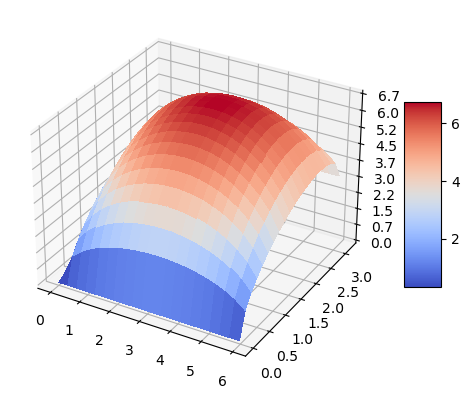

In [57]:
X1, X2 = np.meshgrid(train_theta, train_phi)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, torch.transpose(test_y_matrix, 0, 1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.01f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

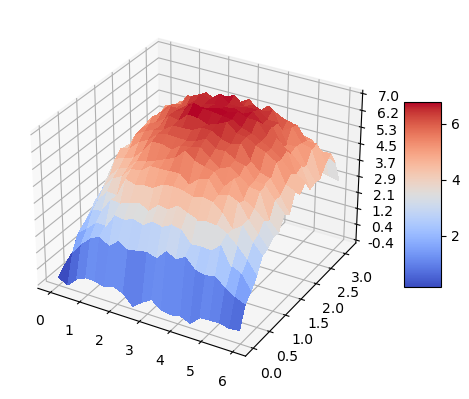

In [58]:
X1, X2 = np.meshgrid(train_theta, train_phi)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, torch.transpose(train_y_matrix, 0, 1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.01f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Training Model

## Varying Depth

### 1-depth model

In [131]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = PGFKernel(width=[5])
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [132]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.224   noise: 0.693
Iter 2/50 - Loss: 1.205   noise: 0.644
Iter 3/50 - Loss: 1.187   noise: 0.598
Iter 4/50 - Loss: 1.171   noise: 0.555
Iter 5/50 - Loss: 1.157   noise: 0.514
Iter 6/50 - Loss: 1.144   noise: 0.476
Iter 7/50 - Loss: 1.133   noise: 0.442
Iter 8/50 - Loss: 1.125   noise: 0.410
Iter 9/50 - Loss: 1.120   noise: 0.382
Iter 10/50 - Loss: 1.117   noise: 0.358
Iter 11/50 - Loss: 1.115   noise: 0.338
Iter 12/50 - Loss: 1.114   noise: 0.323
Iter 13/50 - Loss: 1.114   noise: 0.312
Iter 14/50 - Loss: 1.113   noise: 0.305
Iter 15/50 - Loss: 1.111   noise: 0.303
Iter 16/50 - Loss: 1.108   noise: 0.304
Iter 17/50 - Loss: 1.104   noise: 0.308
Iter 18/50 - Loss: 1.100   noise: 0.314
Iter 19/50 - Loss: 1.095   noise: 0.322
Iter 20/50 - Loss: 1.091   noise: 0.332
Iter 21/50 - Loss: 1.088   noise: 0.343
Iter 22/50 - Loss: 1.085   noise: 0.354
Iter 23/50 - Loss: 1.082   noise: 0.365
Iter 24/50 - Loss: 1.080   noise: 0.375
Iter 25/50 - Loss: 1.079   noise: 0.385
Iter 26/5

In [133]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

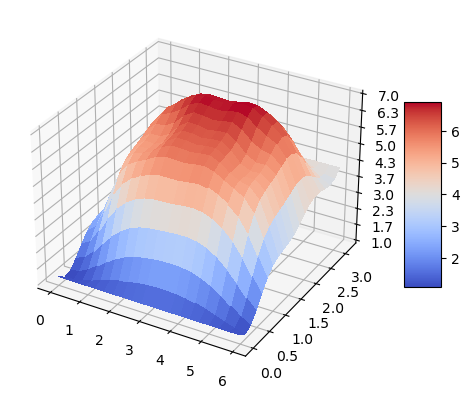

In [134]:
observed_y = observed_pred.mean
observed_y_matrix = observed_y.reshape(train_theta.size()[0], train_phi.size()[0])
X1, X2 = np.meshgrid(train_theta, train_phi)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, torch.transpose(observed_y_matrix, 0, 1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.01f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [135]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
# msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: 0.8415, 
Mean Squared Error: 0.2983, 
Mean Absolute Error: 0.4250


### 2-depth model

In [136]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = PGFKernel(width=[5,5])
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [137]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.185   noise: 0.693
Iter 2/50 - Loss: 1.161   noise: 0.644
Iter 3/50 - Loss: 1.137   noise: 0.598
Iter 4/50 - Loss: 1.113   noise: 0.555
Iter 5/50 - Loss: 1.091   noise: 0.513
Iter 6/50 - Loss: 1.069   noise: 0.475
Iter 7/50 - Loss: 1.048   noise: 0.438
Iter 8/50 - Loss: 1.028   noise: 0.404
Iter 9/50 - Loss: 1.010   noise: 0.373
Iter 10/50 - Loss: 0.993   noise: 0.344
Iter 11/50 - Loss: 0.978   noise: 0.317
Iter 12/50 - Loss: 0.965   noise: 0.293
Iter 13/50 - Loss: 0.954   noise: 0.270
Iter 14/50 - Loss: 0.945   noise: 0.250
Iter 15/50 - Loss: 0.938   noise: 0.232
Iter 16/50 - Loss: 0.933   noise: 0.217
Iter 17/50 - Loss: 0.930   noise: 0.203
Iter 18/50 - Loss: 0.928   noise: 0.191
Iter 19/50 - Loss: 0.928   noise: 0.181
Iter 20/50 - Loss: 0.928   noise: 0.173
Iter 21/50 - Loss: 0.929   noise: 0.167
Iter 22/50 - Loss: 0.929   noise: 0.163
Iter 23/50 - Loss: 0.929   noise: 0.160
Iter 24/50 - Loss: 0.927   noise: 0.159
Iter 25/50 - Loss: 0.926   noise: 0.159
Iter 26/5

In [138]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

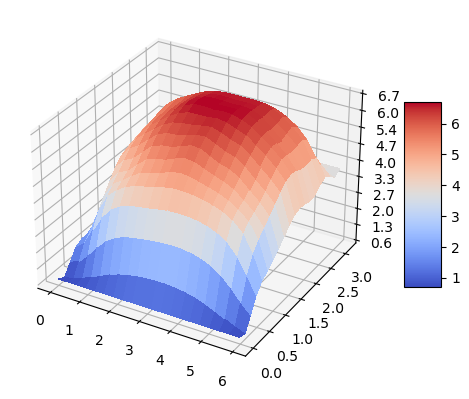

In [139]:
observed_y = observed_pred.mean
observed_y_matrix = observed_y.reshape(train_theta.size()[0], train_phi.size()[0])
X1, X2 = np.meshgrid(train_theta, train_phi)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, torch.transpose(observed_y_matrix, 0, 1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.01f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [140]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
# msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: 0.4957, 
Mean Squared Error: 0.1370, 
Mean Absolute Error: 0.2649


### 3-depth model

In [141]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = PGFKernel(width=[5,5,5])
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [142]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.196   noise: 0.693
Iter 2/50 - Loss: 1.170   noise: 0.644
Iter 3/50 - Loss: 1.143   noise: 0.598
Iter 4/50 - Loss: 1.117   noise: 0.554
Iter 5/50 - Loss: 1.091   noise: 0.513
Iter 6/50 - Loss: 1.066   noise: 0.474
Iter 7/50 - Loss: 1.041   noise: 0.438
Iter 8/50 - Loss: 1.016   noise: 0.404
Iter 9/50 - Loss: 0.992   noise: 0.372
Iter 10/50 - Loss: 0.970   noise: 0.342
Iter 11/50 - Loss: 0.948   noise: 0.315
Iter 12/50 - Loss: 0.927   noise: 0.289
Iter 13/50 - Loss: 0.907   noise: 0.266
Iter 14/50 - Loss: 0.889   noise: 0.244
Iter 15/50 - Loss: 0.872   noise: 0.224
Iter 16/50 - Loss: 0.857   noise: 0.206
Iter 17/50 - Loss: 0.843   noise: 0.190
Iter 18/50 - Loss: 0.831   noise: 0.175
Iter 19/50 - Loss: 0.821   noise: 0.162
Iter 20/50 - Loss: 0.813   noise: 0.150
Iter 21/50 - Loss: 0.806   noise: 0.139
Iter 22/50 - Loss: 0.801   noise: 0.130
Iter 23/50 - Loss: 0.797   noise: 0.121
Iter 24/50 - Loss: 0.795   noise: 0.114
Iter 25/50 - Loss: 0.793   noise: 0.108
Iter 26/5

In [143]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

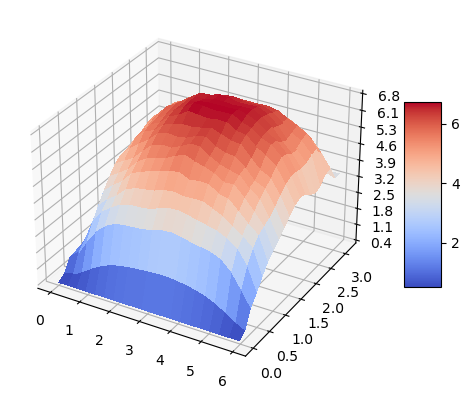

In [144]:
observed_y = observed_pred.mean
observed_y_matrix = observed_y.reshape(train_theta.size()[0], train_phi.size()[0])
X1, X2 = np.meshgrid(train_theta, train_phi)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, torch.transpose(observed_y_matrix, 0, 1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.01f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [145]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
# msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: 0.1864, 
Mean Squared Error: 0.0601, 
Mean Absolute Error: 0.1789


### 4-depth model

In [146]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = PGFKernel(width=[5,5,5,5])
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [147]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.242   noise: 0.693
Iter 2/50 - Loss: 1.216   noise: 0.644
Iter 3/50 - Loss: 1.189   noise: 0.598
Iter 4/50 - Loss: 1.162   noise: 0.554
Iter 5/50 - Loss: 1.136   noise: 0.513
Iter 6/50 - Loss: 1.110   noise: 0.474
Iter 7/50 - Loss: 1.084   noise: 0.438
Iter 8/50 - Loss: 1.058   noise: 0.403
Iter 9/50 - Loss: 1.032   noise: 0.371
Iter 10/50 - Loss: 1.007   noise: 0.341
Iter 11/50 - Loss: 0.983   noise: 0.314
Iter 12/50 - Loss: 0.959   noise: 0.288
Iter 13/50 - Loss: 0.936   noise: 0.264
Iter 14/50 - Loss: 0.914   noise: 0.242
Iter 15/50 - Loss: 0.892   noise: 0.222
Iter 16/50 - Loss: 0.871   noise: 0.203
Iter 17/50 - Loss: 0.851   noise: 0.186
Iter 18/50 - Loss: 0.833   noise: 0.171
Iter 19/50 - Loss: 0.815   noise: 0.156
Iter 20/50 - Loss: 0.798   noise: 0.143
Iter 21/50 - Loss: 0.783   noise: 0.132
Iter 22/50 - Loss: 0.768   noise: 0.121
Iter 23/50 - Loss: 0.755   noise: 0.111
Iter 24/50 - Loss: 0.743   noise: 0.102
Iter 25/50 - Loss: 0.733   noise: 0.094
Iter 26/5

In [148]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

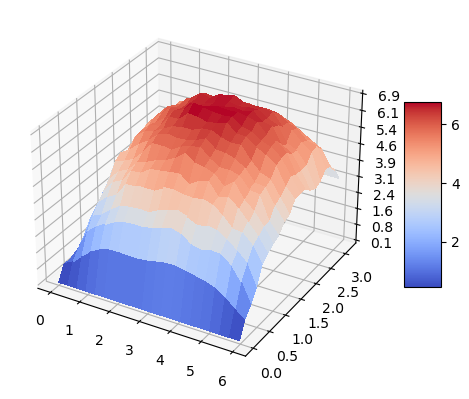

In [149]:
observed_y = observed_pred.mean
observed_y_matrix = observed_y.reshape(train_theta.size()[0], train_phi.size()[0])
X1, X2 = np.meshgrid(train_theta, train_phi)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, torch.transpose(observed_y_matrix, 0, 1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.01f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [150]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
# msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -0.2874, 
Mean Squared Error: 0.0240, 
Mean Absolute Error: 0.1178


### 5-depth model

In [151]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = PGFKernel(width=[5,5,5,5,5])
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [152]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.324   noise: 0.693
Iter 2/50 - Loss: 1.299   noise: 0.644
Iter 3/50 - Loss: 1.275   noise: 0.598
Iter 4/50 - Loss: 1.250   noise: 0.554
Iter 5/50 - Loss: 1.225   noise: 0.513
Iter 6/50 - Loss: 1.201   noise: 0.474
Iter 7/50 - Loss: 1.177   noise: 0.438
Iter 8/50 - Loss: 1.153   noise: 0.403
Iter 9/50 - Loss: 1.130   noise: 0.371
Iter 10/50 - Loss: 1.107   noise: 0.341
Iter 11/50 - Loss: 1.084   noise: 0.314
Iter 12/50 - Loss: 1.062   noise: 0.288
Iter 13/50 - Loss: 1.041   noise: 0.264
Iter 14/50 - Loss: 1.020   noise: 0.242
Iter 15/50 - Loss: 1.000   noise: 0.222
Iter 16/50 - Loss: 0.981   noise: 0.203
Iter 17/50 - Loss: 0.962   noise: 0.186
Iter 18/50 - Loss: 0.945   noise: 0.171
Iter 19/50 - Loss: 0.928   noise: 0.156
Iter 20/50 - Loss: 0.912   noise: 0.143
Iter 21/50 - Loss: 0.897   noise: 0.131
Iter 22/50 - Loss: 0.883   noise: 0.121
Iter 23/50 - Loss: 0.870   noise: 0.111
Iter 24/50 - Loss: 0.857   noise: 0.102
Iter 25/50 - Loss: 0.846   noise: 0.094
Iter 26/5

In [153]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

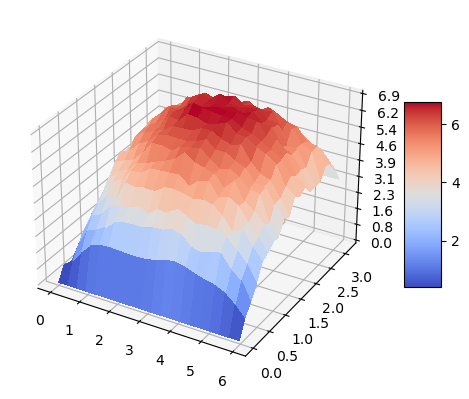

In [154]:
observed_y = observed_pred.mean
observed_y_matrix = observed_y.reshape(train_theta.size()[0], train_phi.size()[0])
X1, X2 = np.meshgrid(train_theta, train_phi)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, torch.transpose(observed_y_matrix, 0, 1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.01f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [155]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
# msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -0.3101, 
Mean Squared Error: 0.0267, 
Mean Absolute Error: 0.1262


## Varying Kernel

In [126]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [127]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.232   noise: 0.693
Iter 2/50 - Loss: 1.190   noise: 0.644
Iter 3/50 - Loss: 1.149   noise: 0.598
Iter 4/50 - Loss: 1.110   noise: 0.554
Iter 5/50 - Loss: 1.071   noise: 0.513
Iter 6/50 - Loss: 1.035   noise: 0.474
Iter 7/50 - Loss: 0.999   noise: 0.437
Iter 8/50 - Loss: 0.966   noise: 0.402
Iter 9/50 - Loss: 0.935   noise: 0.370
Iter 10/50 - Loss: 0.905   noise: 0.340
Iter 11/50 - Loss: 0.877   noise: 0.312
Iter 12/50 - Loss: 0.850   noise: 0.285
Iter 13/50 - Loss: 0.824   noise: 0.261
Iter 14/50 - Loss: 0.799   noise: 0.239
Iter 15/50 - Loss: 0.775   noise: 0.218
Iter 16/50 - Loss: 0.751   noise: 0.199
Iter 17/50 - Loss: 0.729   noise: 0.182
Iter 18/50 - Loss: 0.708   noise: 0.166
Iter 19/50 - Loss: 0.690   noise: 0.151
Iter 20/50 - Loss: 0.672   noise: 0.138
Iter 21/50 - Loss: 0.656   noise: 0.126
Iter 22/50 - Loss: 0.641   noise: 0.116
Iter 23/50 - Loss: 0.627   noise: 0.106
Iter 24/50 - Loss: 0.614   noise: 0.097
Iter 25/50 - Loss: 0.603   noise: 0.089
Iter 26/5

In [128]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


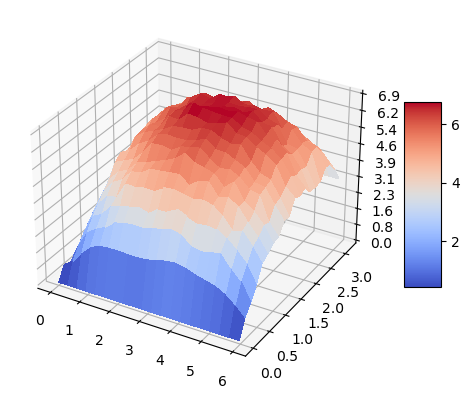

In [129]:
observed_y = observed_pred.mean
observed_y_matrix = observed_y.reshape(train_theta.size()[0], train_phi.size()[0])
X1, X2 = np.meshgrid(train_theta, train_phi)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, torch.transpose(observed_y_matrix, 0, 1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.01f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [130]:
nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
# msll = gpytorch.metrics.mean_standardized_log_loss(observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -0.3660, 
Mean Squared Error: 0.0228, 
Mean Absolute Error: 0.1155


### Parameter Tuning

In [119]:
import pandas as pd
df = pd.DataFrame(columns=['Shape','NLPD','MSE','MAE'])
df

,Shape,NLPD,MSE,MAE


In [120]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kwidth):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = PGFKernel(width=kwidth)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [121]:
def train(w):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, w)
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(train_x))
    nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
    mse = gpytorch.metrics.mean_squared_error(observed_pred, test_y, squared=True)
    mae = gpytorch.metrics.mean_absolute_error(observed_pred, test_y)
    return nlpd, mse, mae

In [122]:
def test_shape(w, df):
    if str(w) in list(df['Shape']):
        idx = df[df['Shape'] == str(w)].index[0]
        mse = df['MSE'][idx]
    else:
        nlpd, mse, mae = train(w)
        new_row = pd.DataFrame({'Shape':str(w), 'NLPD':nlpd, 'MSE':mse, 'MAE':mae}, index=[0])
        df = pd.concat([df.loc[:],new_row]).reset_index(drop=True)
    return mse, df

In [123]:
p = [0,1,2,3]
w = [8,8,8,8]
best_mse, df = test_shape(w, df)
for a in range(4):
    q = p.copy()
    p1 = q[a]
    q.remove(p1)
    for b in range(3):
        r = q.copy()
        p2 = r[b]
        r.remove(p2)
        for c in range(2):
            s = r.copy()
            p3 = s[c]
            s.remove(p3)
            p4 = s[0]
            order = [p1,p2,p3,p4]
            for i in range(4):
                w[order[i]] = 7
                mse, df = test_shape(w, df)
                if mse < best_mse:
                    best_mse = mse
                    better = True
                    while better:
                        w[order[i]] = w[order[i]] - 1
                        mse, df = test_shape(w, df)
                        if mse < best_mse:
                            best_mse = mse
                        else:
                            better = False
                            w[order[i]] = w[order[i]] + 1
                else:
                    w[order[i]] = 9
                    mse, df = test_shape(w, df)
                    if mse < best_mse:
                        best_mse = mse
                        better = True
                        while better:
                            w[order[i]] = w[order[i]] + 1
                            mse, df = test_shape(w, df)
                            if mse < best_mse:
                                best_mse = mse
                            else:
                                better = False
                                w[order[i]] = w[order[i]] - 1
                    else:
                        w[order[i]] = 8

/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packa

In [124]:
df.to_csv('tuning3.csv')

In [125]:
df

,Shape,NLPD,MSE,MAE
0,"[8, 8, 8, 8]",tensor(-0.2411),tensor(0.0299),tensor(0.1339)
1,"[7, 8, 8, 8]",tensor(-0.2473),tensor(0.0298),tensor(0.1334)
2,"[6, 8, 8, 8]",tensor(-0.2547),tensor(0.0296),tensor(0.1328)
3,"[5, 8, 8, 8]",tensor(-0.2642),tensor(0.0293),tensor(0.1318)
4,"[4, 8, 8, 8]",tensor(-0.2771),tensor(0.0287),tensor(0.1308)
5,"[3, 8, 8, 8]",tensor(-0.2937),tensor(0.0277),tensor(0.1287)
6,"[2, 8, 8, 8]",tensor(-0.3092),tensor(0.0245),tensor(0.1188)
7,"[1, 8, 8, 8]",tensor(2.0046),tensor(3.1773),tensor(1.4561)
8,"[2, 7, 8, 8]",tensor(-0.2786),tensor(0.0245),tensor(0.1189)
9,"[2, 9, 8, 8]",tensor(-0.3150),tensor(0.0251),tensor(0.1208)


In [107]:
def test_shape2(w, df):
    if str(w) in list(df['Shape']):
        idx = df[df['Shape'] == str(w)].index[0]
        nlpd = df['NLPD'][idx]
    else:
        nlpd, mse, mae = train(w)
        new_row = pd.DataFrame({'Shape':str(w), 'NLPD':nlpd, 'MSE':mse, 'MAE':mae}, index=[0])
        df = pd.concat([df.loc[:],new_row]).reset_index(drop=True)
    return nlpd, df

In [109]:
p = [0,1,2,3]
w = [5,5,5,5]
best_nlpd, df = test_shape2(w, df)
for a in range(4):
    q = p.copy()
    p1 = q[a]
    q.remove(p1)
    for b in range(3):
        r = q.copy()
        p2 = r[b]
        r.remove(p2)
        for c in range(2):
            s = r.copy()
            p3 = s[c]
            s.remove(p3)
            p4 = s[0]
            order = [p1,p2,p3,p4]
            for i in range(4):
                w[order[i]] = 4
                nlpd, df = test_shape2(w, df)
                if nlpd < best_nlpd:
                    best_nlpd = nlpd
                    better = True
                    while better:
                        w[order[i]] = w[order[i]] - 1
                        nlpd, df = test_shape2(w, df)
                        if nlpd < best_nlpd:
                            best_nlpd = nlpd
                        else:
                            better = False
                            w[order[i]] = w[order[i]] + 1
                else:
                    w[order[i]] = 6
                    nlpd, df = test_shape2(w, df)
                    if nlpd < best_nlpd:
                        best_nlpd = nlpd
                        better = True
                        while better:
                            w[order[i]] = w[order[i]] + 1
                            nlpd, df = test_shape2(w, df)
                            if nlpd < best_nlpd:
                                best_nlpd = nlpd
                            else:
                                better = False
                                w[order[i]] = w[order[i]] - 1
                    else:
                        w[order[i]] = 5

/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packa

In [110]:
df.to_csv('tuning2.csv')

In [111]:
df

,Shape,NLPD,MSE,MAE
0,"[5, 5, 5, 5]",-0.2874,0.024,0.1178
1,"[4, 5, 5, 5]",tensor(-0.1266),tensor(0.0306),tensor(0.1374)
2,"[6, 5, 5, 5]",tensor(-0.3207),tensor(0.0243),tensor(0.1187)
3,"[5, 4, 5, 5]",tensor(-0.1369),tensor(0.0300),tensor(0.1360)
4,"[5, 6, 5, 5]",tensor(-0.3200),tensor(0.0243),tensor(0.1186)
5,"[5, 5, 4, 5]",tensor(-0.1550),tensor(0.0291),tensor(0.1335)
6,"[5, 5, 6, 5]",tensor(-0.3187),tensor(0.0243),tensor(0.1185)
7,"[5, 5, 5, 4]",tensor(-0.1829),tensor(0.0276),tensor(0.1297)
8,"[5, 5, 5, 6]",tensor(-0.3162),tensor(0.0243),tensor(0.1183)
9,"[5, 5, 5, 5]",-0.2874,0.024,0.1178
